In [1]:
%pylab qt
%matplotlib inline

from pyinstruments import CurveDB
import pandas
import scipy.constants as cst

dpi = 200
def mysavefig(name):
    plt.tight_layout()
    plt.savefig(name, bbox_inches="tight", dpi=dpi)

Populating the interactive namespace from numpy and matplotlib


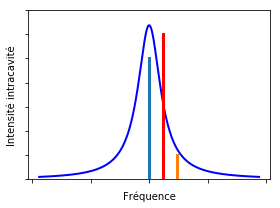

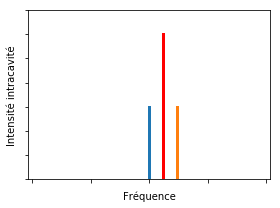

In [3]:
length = 100e-6
tau = 2.*length/3e8
isl = 1./tau

def intracavity(delta, T, x0):
    kappa = T/tau
    ampl = np.sqrt(kappa/tau)/(kappa/2.-1.j*(delta-x0))
    return np.abs(ampl)**2

delta = np.linspace(-0.25*isl,0.25*isl, 1001)

f=100
fig, ax = plt.subplots(1,1,figsize=(4,3))
T = 2*np.pi/f
y = (intracavity(delta, T, 0*isl))
plt.plot(delta, y, "b", alpha=1, linewidth = 2)
ax.set_ylim(0,70)
kappa = T/tau
x0 = kappa/2.
ax.plot([x0, x0], [0,60], "r", linewidth=3)
x0 = 0
ax.plot([x0, x0], [0,50], "C0", linewidth=3)
x0 = kappa
ax.plot([x0, x0], [0,10], "C1", linewidth=3)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel(u"Fréquence")
ax.set_ylabel(u"Intensité intracavité")
ax.set_xlim(min(delta)*1.1, max(delta)*1.1)
mysavefig("intracvity_intensity_sbcooling_laser_and_sb_and_res.png")

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel(u"Fréquence")
ax.set_ylabel(u"Intensité intracavité")
ax.set_xlim(min(delta)*1.1, max(delta)*1.1)
ax.set_ylim(0,70)
kappa = T/tau
x0 = kappa/2.
ax.plot([x0, x0], [0,60], "r", linewidth=3)
mysavefig("intracvity_intensity_sbcooling_laser_only.png")  
x0 = 0
ax.plot([x0, x0], [0,30], "C0", linewidth=3)
x0 = kappa
ax.plot([x0, x0], [0,30], "C1", linewidth=3)
mysavefig("intracvity_intensity_sbcooling_laser_and_sb.png")  

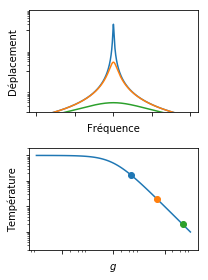

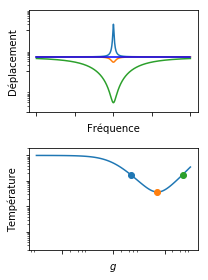

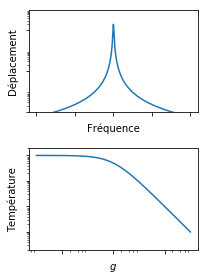

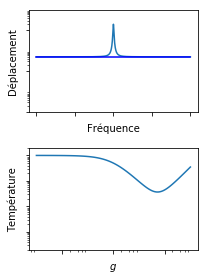

In [51]:
##### SQL #####

def I(P, wavelength=1064e-9):
    nu = cst.c/wavelength
    return P/cst.h/nu

def phase_noise(P,F, wavelength=1064e-9):
    return wavelength/16./F/np.sqrt(I(P, wavelength=wavelength))

def Sxx_phase(P,F, wavelength=1064e-9):
    return (phase_noise(P,F, wavelength=wavelength))**2

def chi(f, m=33.5e-9, f0=3.6e6, Q=1e6):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    return 1./m/((omega0**2-omega**2)-1j*gamma*omega)

def Sxx_ampl(f, P, F, wavelength=1064e-9, m=33.5e-9, f0=3.6e6, Q=1e6):
    omega = 2.*np.pi*f
    return 64.*cst.hbar**2*F**2*np.abs(chi(f, m=m, f0=f0, Q=Q))**2*I(P, wavelength=wavelength)/wavelength**2

def thermal_peak(f, m=33.5e-9, f0=3.6e6, Q=1e6, T=00.):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    return 2.*cst.k*T*gamma/m/((omega0**2-omega**2)**2+gamma**2*omega**2)

## Rugar
def Sxx(f, m=33.5e-9, f0=3.6e6, Q=1e6, T=300., Sxn=0., g=0.):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    susc = 1./((omega0**2-omega**2)**2+(1.+g)**2*gamma**2*omega**2)
    thermal = 2.*cst.k*T*gamma/m
    noise = g**2*gamma**2*omega**2*Sxn
    return susc*(thermal+noise)

def Sxx_meas(f, m=33.5e-9, f0=3.6e6, Q=1e6, T=300., Sxn=0., g=0.):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    susc = 1./((omega0**2-omega**2)**2+(1.+g)**2*gamma**2*omega**2)
    thermal = 2.*cst.k*T*gamma/m
    noise = ((omega0**2-omega**2)**2+gamma**2*omega**2)*Sxn
    return susc*(thermal+noise)

fig = plt.figure(figsize=(3,4))
sps = (2,1)
ax1 = plt.subplot2grid(sps, (0,0))
ax4 = plt.subplot2grid(sps, (1,0))

T = 100e-3
f0 = 3.6e6
meff = 33.5e-9
Q = 1e6
F = 60e3
span = 4000.
f = np.linspace(f0-span/2., f0+span/2, 1001)
x = (f-f0)
P = 1e-6
Sxn = Sxx_phase(P,F)
omega0 = 2.*np.pi*f0
gamma = omega0/Q

Teffs = []
gain = [5, 50, 500]
for i, g in enumerate(gain):
    Tenv = T
    Teff = Tenv/(1.+g)
    Teffs.append(Teff)
    
    y_thermal = thermal_peak(f, m=meff, f0=f0, Q=Q/(1+g), T=Teff)
    ax1.semilogy(x, y_thermal, "C"+str(i))
    ax1.set_ylim(1e-38, 1e-33)
    ax1.set_xlabel(u"Fréquence")
ax1.set_ylabel(u"Déplacement")

g = np.logspace(-3,3, 101)
Sxn = 0
Teff = Tenv/(1.+g) + meff*gamma*omega0**2/4/cst.k * (g**2/(1.+g))*Sxn
ax4.loglog(g, Teff)
ax4.set_xlabel("$g$")
for g, Teff, i in zip(gain, Teffs, [0,1,2]):
    ax4.plot([g], [Teff], "oC"+str(i))

for ax in [ax1, ax4]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

ax4.set_ylabel(u"Température")
ax4.set_ylim(2e-5, 2e-1)
plt.tight_layout()

mysavefig("feedback_cooling_theo_def_nonoise.png")

fig = plt.figure(figsize=(3,4))
sps = (2,1)
ax1 = plt.subplot2grid(sps, (0,0))
ax4 = plt.subplot2grid(sps, (1,0))
Sxn = 5e-36

Teffs = []
gain = [5, 50, 500]
for i, g in enumerate(gain):
    Tenv = T
    Teff = Tenv/(1.+g) + meff*gamma*omega0**2/4/cst.k * (g**2/(1.+g))*Sxn
    Teffs.append(Teff)
    
    y_thermal = thermal_peak(f, m=meff, f0=f0, Q=Q/(1+g), T=Teff)
    y_meas_rug = Sxx_meas(f, m=meff, f0=f0, Q=Q, T=Tenv, Sxn=Sxn, g=g)

    ax1.semilogy(x, y_meas_rug, "C"+str(i))
    ax1.set_ylim(1e-38, 1e-33)
    ax1.set_xlabel(u"Fréquence")
ax1.set_ylabel(u"Déplacement")
y_phase = Sxn*np.ones(len(x))
ax1.semilogy(x, y_phase, "b")

g = np.logspace(-3,3, 101)
Teff = Tenv/(1.+g) + meff*gamma*omega0**2/4/cst.k * (g**2/(1.+g))*Sxn
ax4.loglog(g, Teff)
ax4.set_xlabel("$g$")
for g, Teff, i in zip(gain, Teffs, [0,1,2]):
    ax4.plot([g], [Teff], "oC"+str(i))

for ax in [ax1, ax4]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

ax4.set_ylabel(u"Température")
ax4.set_ylim(2e-5, 2e-1)
plt.tight_layout()

mysavefig("feedback_cooling_theo_def_noise.png")

fig = plt.figure(figsize=(3,4))
sps = (2,1)
ax1 = plt.subplot2grid(sps, (0,0))
ax4 = plt.subplot2grid(sps, (1,0))
Sxn =0

g = gain[0]
Tenv = T
Teff = Tenv/(1.+g)
Teffs.append(Teff)

y_thermal = thermal_peak(f, m=meff, f0=f0, Q=Q/(1+g), T=Teff)
ax1.semilogy(x, y_thermal, "C"+str(0))
ax1.set_ylim(1e-38, 1e-33)
ax1.set_xlabel(u"Fréquence")
ax1.set_ylabel(u"Déplacement")

g = np.logspace(-3,3, 101)
Sxn = 0
Teff = Tenv/(1.+g) + meff*gamma*omega0**2/4/cst.k * (g**2/(1.+g))*Sxn
ax4.loglog(g, Teff)
ax4.set_xlabel("$g$")

for ax in [ax1, ax4]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

ax4.set_ylabel(u"Température")
ax4.set_ylim(2e-5, 2e-1)
plt.tight_layout()

mysavefig("feedback_cooling_theo_def_nonoise_spectrum.png")

fig = plt.figure(figsize=(3,4))
sps = (2,1)
ax1 = plt.subplot2grid(sps, (0,0))
ax4 = plt.subplot2grid(sps, (1,0))
Sxn = 5e-36

Teffs = []
gain = [5, 50, 500]
g = gain[0]
Tenv = T
Teff = Tenv/(1.+g) + meff*gamma*omega0**2/4/cst.k * (g**2/(1.+g))*Sxn
Teffs.append(Teff)

y_thermal = thermal_peak(f, m=meff, f0=f0, Q=Q/(1+g), T=Teff)
y_meas_rug = Sxx_meas(f, m=meff, f0=f0, Q=Q, T=Tenv, Sxn=Sxn, g=g)

ax1.semilogy(x, y_meas_rug, "C"+str(0))
ax1.set_ylim(1e-38, 1e-33)
ax1.set_xlabel(u"Fréquence")
ax1.set_ylabel(u"Déplacement")
y_phase = Sxn*np.ones(len(x))
ax1.semilogy(x, y_phase, "b")

g = np.logspace(-3,3, 101)
Teff = Tenv/(1.+g) + meff*gamma*omega0**2/4/cst.k * (g**2/(1.+g))*Sxn
ax4.loglog(g, Teff)
ax4.set_xlabel("$g$")

for ax in [ax1, ax4]:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

ax4.set_ylabel(u"Température")
ax4.set_ylim(2e-5, 2e-1)
plt.tight_layout()

mysavefig("feedback_cooling_theo_def_noise_spectrum.png")

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3242: FutureWarning: get_store is deprecated and be removed in a future version
HDFStore(path, **kwargs) is the replacement
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\OMQ\Documents\Github\pyinstruments\curve\fitting.py:1034: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  x0 = magdata.argmax()#float(self.x()[magdata.argmax()])


293.9409289579889 1726206.9392429418
0.03158864601722272 912809.6249175644


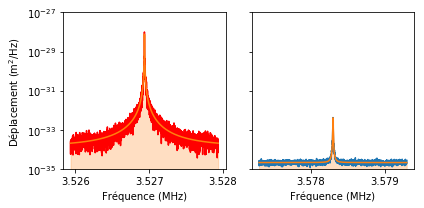

In [20]:
plt.figure(figsize=(6,3))

def dBmtoW(dbm):
    return 1e-3 * 10. ** (dbm / 10.)

def WtoVsquared(w):
    return w * 50.

def dBmtoVsquared(dbm):
    w = dBmtoW(dbm)
    vsquared = WtoVsquared(w)
    return vsquared

def mod_depth(dbm=-21.5):
    vsquared = dBmtoVsquared(dbm)
    v = np.sqrt(vsquared)
    return np.pi * v / calibration_marker_Vpi

sps =(1,2)
ax1 = plt.subplot2grid(sps, (0,0))
ax2 = plt.subplot2grid(sps, (0,1))

c = CurveDB.get(94188)
center = 3.526935e6
span = 2000
length = 82e-6
calibration_marker_frequency = 3.6e6
calibration_marker_Vpi = 5.89
mass = 33.5e-9

dbm = CurveDB()
dbm.data = c.data[center - span / 2.:center + span / 2.]
vsquared = CurveDB()
vsquared.data = pandas.Series(dBmtoVsquared(dbm.data.values), index=dbm.data.index)
mod = dBmtoVsquared(-69.3)
xeq = length / (3e8 / 1064e-9) * calibration_marker_frequency * mod_depth()
mperV = xeq / np.sqrt(mod)
# in meters squared
msquared = CurveDB()
msquared.data = pandas.Series(vsquared.data.values * mperV ** 2, index=vsquared.data.index)
# calibrated spectrum
msquaredperhz = CurveDB()
msquaredperhz.data = pandas.Series(msquared.data.values / c.params["bandwidth"], index=msquared.data.index)
fit = msquaredperhz.fit("lorentz", error_function="log_error_vector", autosave=False)
teff = fit.params["Area"] * mass * (2. * np.pi * fit.params["x0"]) ** 2 / cst.k

c = msquaredperhz
ax1.semilogy(c.data.index.values*1e-6, c.data.values, "r")
ax1.semilogy(fit.data.index.values*1e-6, fit.data.values, "C1")
ax1.fill_between(fit.data.index.values*1e-6, 1e-35, fit.data.values, color='C1', alpha=0.25)
print(teff, fit.params["Q"])

c = CurveDB.get(83833)
fit = c.childs.last()
x0 = fit.params["x0"]
ax2.semilogy(c.data.index.values*1e-6, c.data.values)
ax2.semilogy(fit.data.index.values*1e-6, fit.data.values)
ax2.fill_between(fit.data.index.values*1e-6, 1e-35, fit.data.values, color='C1', alpha=0.25)

fit = c.fit("lorentz", error_function="log_error_vector", autosave=False)
teff = fit.params["Area"] * mass * (2. * np.pi * fit.params["x0"]) ** 2 / cst.k
print(teff, fit.params["Q"])
for ax in [ax1, ax2]:
    ax.set_ylim(1e-35, 1e-27)
    ax.set_xlabel(u"Fréquence (MHz)")
    
ax1.set_ylabel(u"Déplacement ($\mathrm{m^2/Hz}$)")
ax2.set_yticklabels([])
ax1.set_xticks([3.526,3.527,3.528])
ax2.set_xticks([3.578,3.579])

plt.tight_layout()
mysavefig("thermal_peak_def_filled.png")

In [9]:
CurveDB.

dict_keys(['name', 'comment', 'curve_type', 'data_read_only', 'date', 'id', 'parent_id', 'tags_flatten', 'user_has_read', 'window'])

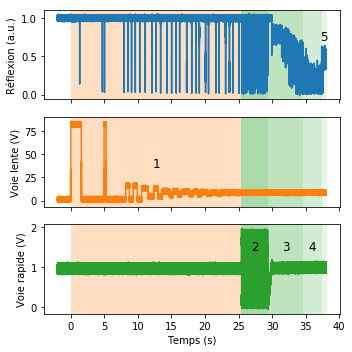

In [11]:
%matplotlib inline

c = CurveDB.get(92312)
cc = c.childs.first()
ccc = c.childs.last()
#cc = cc.data_filter(window_length=11, save=False)
#ccc = ccc.data_filter(window_length=11, save=False)

plt.figure(figsize=(5,5))
sps =(3,1)
ax1 = plt.subplot2grid(sps, (0,0))
ax2 = plt.subplot2grid(sps, (1,0))
ax3 = plt.subplot2grid(sps, (2,0))

offset = 18.03
ax1.plot(c.data.index+offset, c.data.values/c.data.values[0:100].mean(), "C0")
ax2.plot(ccc.data.index+offset, ccc.data.values*100, "C1")
ax3.plot(cc.data.index+offset, cc.data.values, "C2")

x1 = 25.4
x2 = 29.45
x3 = 34.6
x4 = 37.35
x5 = 38.1
colormap = plt.cm.jet
colorst = [colormap(i) for i in np.linspace(0, 1, 5)]
for ax in [ax1, ax2, ax3]:
    ax.axvspan(00, x1, facecolor="C1", alpha=0.25)
    ax.axvspan(x1, x2, facecolor="C2", alpha=0.4)
    ax.axvspan(x2, x3, facecolor="C2", alpha=0.3)
    ax.axvspan(x3, x4, facecolor="C2", alpha=0.2)
    ax.axvspan(x4, x5, facecolor="C2", alpha=0.1)

xs = np.array([0, x1, x2, x3, x4, x5])
for i, x in enumerate((xs[1:]+xs[:-1])/2.):
    n = len(xs)-1
    if i==0:
        ax2.text(x, 40, str(i+1), verticalalignment="center", horizontalalignment="center", fontsize=12)
    elif i==4:
        ax1.text(x, 0.75, str(i+1), verticalalignment="center", horizontalalignment="center", fontsize=12)
    else:
        ax3.text(x, 1.5, str(i+1), verticalalignment="center", horizontalalignment="center", fontsize=12)
    
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_ylabel(u"Réflexion (a.u.)")
ax2.set_ylabel("Voie lente (V)")
ax3.set_xlabel("Temps (s)")
ax3.set_ylabel("Voie rapide (V)")
mysavefig("locking_sequence_def.png")

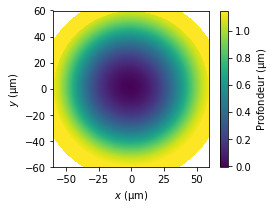

In [10]:
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from users.remi import colormaps as cmaps
%matplotlib inline
from pyinstruments import CurveDB

folder = "Y:/Manip/uRoC_fabrication/15-10_data_from_photoablation_setup/S_series_(old_samples)/S6-4"
filename = 'fiber0002'

folder = "Y:/Manip/uRoC_fabrication/15-10_data_from_photoablation_setup/201510_leonhard_Remi/Samples/S15-10/"
filename = 'fiber0005'

reader = pickle.load(open(folder+'/'+filename+'.p', 'rb'))
profile = reader.get('profile')
pixelCal = reader.get('pixelCal')
nx_pixels = len(profile)
ny_pixels = len(profile[0])
x = (np.arange(0,nx_pixels) - nx_pixels/2) * pixelCal[0]
y = (np.arange(0,ny_pixels) - ny_pixels/2) * pixelCal[1]
X,Y = np.meshgrid(x, y)


for j in range(len(x)):
    for i in range(len(y)):
        if x[j]**2+y[i]**2 >= 70**2:
            profile[j][i] = np.nan


fig, ax = plt.subplots(1,1, figsize=(4,3))
plt.contourf(x,y,profile, 500)
cbar = plt.colorbar(ticks=np.arange(0,1.4, 0.2))
ax.set_aspect('equal')
ax.set_xlabel(r"$x\mathrm{\ (\mu m)}$")
ax.set_ylabel(r"$y\mathrm{\ (\mu m)}$")
cbar.ax.set_ylabel(r"$\mathrm{Profondeur\ (\mu m)}$")

mysavefig("uroc_profile_def.png")

fit_exponentialoffset_of_70924


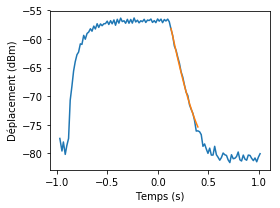

In [6]:
%matplotlib inline

c = CurveDB.get(70921)
fit = c.childs.filter(_name__contains="fit")[0]
fig, ax = plt.subplots(1,1, figsize=(4,3))

ax.set_ylabel(u"Déplacement (dBm)")
ax.set_xlabel(u"Temps (s)")
ax.plot(c.data.index.values, 10.*np.log(np.abs(c.data.values)))
data = fit.data[0:0.4]
print fit.name
ax.plot(data.index.values, 10.*np.log(np.abs(data.values)))

mysavefig("ringdown.png")

In [ ]:
scale = 0.75
plt.figure(1, figsize=(scale*8, scale*6))
plt.clf()
sbs = (1,2)

x0 = c.params["x0"]
x1 = 3.6
data1 = c.data[x0-0.1:x0+0.5]
data2 = c.data[x1-0.1:x1+0.75]
fit = c.childs.first()
slope, y0 = fit.params["slope"], fit.params["y0"]

ax = plt.subplot2grid(sbs, (0,0))
plt.title(u"$\mathrm{Ringup}$")
plt.plot(data1.index.values-x0, data1.values, label=u"$\mathrm{Données\ expérimentales}$")
plt.xlim(-0.1, +0.5)
plt.ylim(-120,0)
plt.xlabel(u"$\mathrm{Temps\ (s)}$")
plt.ylabel(u"$\mathrm{Puissance\ de\ bruit\ (dBm)}$")
plt.legend(loc="lower right", prop={"size":10})

ax = plt.subplot2grid(sbs, (0,1))
plt.title(u"$\mathrm{Ringdown}$")
plt.plot(data2.index.values-x1, data2.values, label=u"$\mathrm{Données\ expérimentales}$")
plt.xlim(-0.1, +0.5)
plt.ylim(-120,0)
ax.set_yticklabels([])
plt.xlabel(u"$\mathrm{Temps\ (s)}$")
plt.plot(data2.index.values-x1, slope*data2.index.values+y0, label=u"$\mathrm{Ajustement\ linéaire}$")
plt.legend(loc="best", prop={"size":10})

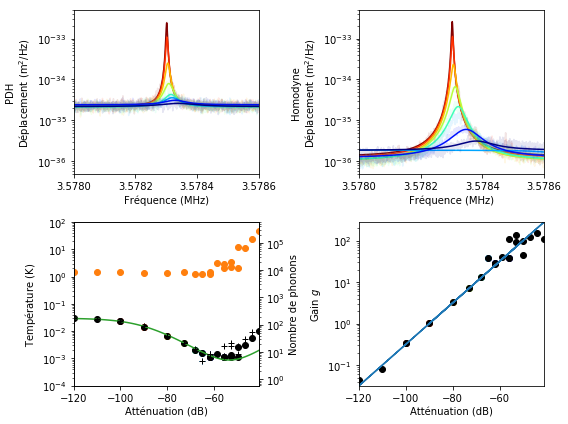

In [6]:
#Calibrated spectra

%matplotlib inline

from users.remi import feedback_cooling as fc
from users.remi import thermometry as th
import matplotlib.colors as mcol
import matplotlib.cm as cm

parent = CurveDB.get(184307)
curves = parent.childs.all()

Q = 1.04e6

fig = plt.figure(figsize=(8,6))

sps = (2,2)
ax1 = plt.subplot2grid(sps, (0,0))
ax2 = plt.subplot2grid(sps, (1,0))
ax3 = plt.subplot2grid(sps, (0,1))
ax4 = plt.subplot2grid(sps, (1,1))
ax1.set_ylabel(u"PDH\n$\\rm{Déplacement\ (m^2/Hz)}$")
ax3.set_ylabel(u"Homodyne\n$\\rm{Déplacement\ (m^2/Hz)}$")
ax1.set_xlabel(u"Fréquence (MHz)")
ax3.set_xlabel(u"Fréquence (MHz)")
ax2.set_xlabel(u"Atténuation (dB)")
ax2.set_ylabel(u"$\\rm{Température \ (K)}$")
ax4.set_xlabel(u"Atténuation (dB)")
ax4.set_ylabel(u"Gain $g$")

for ax in [ax1, ax3]:
    ax.set_ylim(5e-37, 5e-33)
    ax.set_xlim((fc.center-250)*1e-6, (fc.center+250)*1e-6)
    ax.set_xticks([3.578, 3.5782, 3.5784, 3.5786])

gain, teff, tenv, nph, Qs, x0 = [], [], [], [], [], []
gain_hom, teff_hom, tenv_hom, nph_hom, Qs_hom, x0_hom, teff_hom_rugar, tenv_hom_rugar, gain_hom_rugar, teff_ba = [], [], [], [], [], [], [], [], [], []
i = 0
for peak in curves[:]:
    fit = peak.childs.filter(_name__contains="fit")[0]
    if peak.params["gain"] >-150 and peak.params["gain"]<-40:
        gain.append(peak.params["gain"])
        teff.append(peak.params["Teff"])
        tenv.append(peak.params["Tenv"])
        nph.append(peak.params["nph"])
        Qs.append(fit.params["Q"])
        x0.append(fit.params["x0"])
        peak_hom = peak.childs.filter(_name__contains="vsa")[0]
        fit_hom_rugar = peak_hom.childs.last()
        gain_hom.append(peak.params["gain"])
        teff_hom.append(peak_hom.params["Teff"])
        tenv_hom.append(peak_hom.params["Tenv"])
        nph_hom.append(peak_hom.params["nph"])
        teff_hom_rugar.append(fit_hom_rugar.params["Teff"])
        tenv_hom_rugar.append(fit_hom_rugar.params["Tenv"])
        gain_hom_rugar.append(fit_hom_rugar.params["g"])    
    
usefullgain = [-56, -62, -65, -68, -73, -80, -90, -100][::-1]
colormap = plt.cm.jet
colorst = [colormap(i) for i in np.linspace(0, 1, len(usefullgain))][::-1]
for i, g in enumerate(usefullgain):
    for peak in curves:
        if peak.params["gain"]==g and peak.pk not in [184320,184372]:          
            fit = peak.childs.filter(_name__contains="fit")[0]
            ax1.semilogy(peak.data.index.values*1e-6, peak.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            ax1.semilogy(fit.data.index.values*1e-6, fit.data.values,
                        "-", color=colorst[i], label="g = %.0f dB"%(peak.params["gain"]))
            peak_hom = peak.childs.filter(_name__contains="vsa")[0]
            fit_hom_rugar = peak_hom.childs.last()
            ax3.semilogy(peak_hom.data.index.values*1e-6, peak_hom.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            ax3.semilogy(fit_hom_rugar.data.index.values*1e-6, fit_hom_rugar.data.values, "-", color=colorst[i])
            
            ax2.semilogy([g], [peak.params["Teff"]], "o", color=colorst[i])
            ax2.semilogy([g], [fit_hom_rugar.params["Teff"]], "+", color=colorst[i])
            ax4.semilogy([g], [fit_hom_rugar.params["g"]], "o", color=colorst[i])

            plt.tight_layout()
            #mysavefig("feedback_cooling_6phonons_defense"+str(i)+".png")
Tenv = 30e-3
f0 = 3.5783e6
omega0 = 2.*np.pi*f0
meff = 33.5e-9

gamma0 = omega0/Q            

gtheo = 10**(4.5+np.array(gain)/20.)
x = np.linspace(min(gain), max(gain), 101)
Teff = th.Tmode(f0=omega0/2./np.pi, g=10**(4.5+np.array(x)/20.), Sxn=1.e-36, Tenv=30e-3, Q0=Q, mass=meff)
for ax in [ax2, ax4]:
    ax.set_xlim(min(x), max(x))
ax4.set_ylim(min(gtheo), max(gtheo))

ax2.set_ylim(1e-4, 1e2)
ax2b = ax2.twinx()
ax2b.set_yscale("log")
ax2b.set_ylim(cst.k*ax2.get_ylim()[0]/cst.hbar/(2.*np.pi*np.mean(x0)),
              cst.k*ax2.get_ylim()[1]/cst.hbar/(2.*np.pi*np.mean(x0)))
ax2b.set_ylabel("Nombre de phonons")

ax2.semilogy(gain, np.array(teff), "ok", label="$T_{eff}$")
ax2.semilogy(gain, tenv, "oC1", label="$T_{env}$")
ax2.semilogy(x, Teff, "-C2")
ax2.semilogy(gain, teff_hom_rugar, "+k")

ax4.semilogy(gain, gain_hom_rugar, "ok")
ax4.semilogy(gain, gtheo, "-")


plt.tight_layout()
mysavefig("feedback_cooling_6phonons_defense_with_gain.png")

C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py:3242: FutureWarning: get_store is deprecated and be removed in a future version
HDFStore(path, **kwargs) is the replacement
  if (await self.run_code(code, result,  async_=asy)):


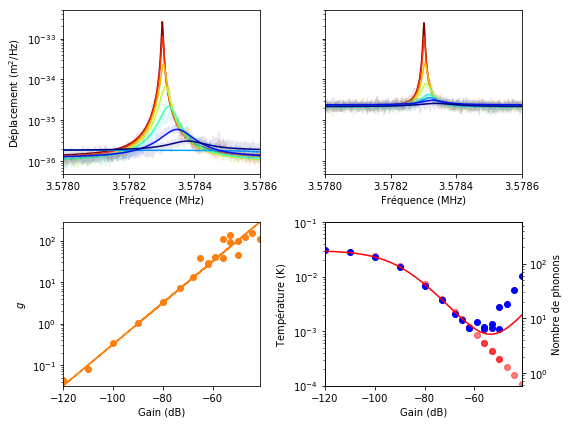

In [30]:
#Calibrated spectra

%matplotlib inline

from users.remi import feedback_cooling as fc
from users.remi import thermometry as th
import matplotlib.colors as mcol
import matplotlib.cm as cm

parent = CurveDB.get(184307)
curves = parent.childs.all()

Q = 1.04e6

fig = plt.figure(figsize=(8,6))

sps = (2,2)
ax3 = plt.subplot2grid(sps, (0,0))
ax4 = plt.subplot2grid(sps, (1,0))
ax1 = plt.subplot2grid(sps, (0,1))
ax2 = plt.subplot2grid(sps, (1,1))
ax3.set_ylabel(u"$\\rm{Déplacement\ (m^2/Hz)}$")
ax1.set_xlabel(u"Fréquence (MHz)")
ax3.set_xlabel(u"Fréquence (MHz)")
ax2.set_xlabel(u"Gain (dB)")
ax2.set_ylabel(u"$\\rm{Température \ (K)}$")
ax4.set_xlabel(u"Gain (dB)")
ax4.set_ylabel(u"$g$")

for ax in [ax1, ax3]:
    ax.set_ylim(5e-37, 5e-33)
    ax.set_xlim((3578300.-250)*1e-6, (3578300.+250)*1e-6)
    ax.set_xticks([3.578, 3.5782, 3.5784, 3.5786])
    
gain, teff, tenv, nph, Qs, x0 = [], [], [], [], [], []
gain_hom, teff_hom, tenv_hom, nph_hom, Qs_hom, x0_hom, teff_hom_rugar, tenv_hom_rugar, gain_hom_rugar, teff_ba = [], [], [], [], [], [], [], [], [], []
i = 0
for peak in curves[:]:
    fit = peak.childs.filter(_name__contains="fit")[0]
    if peak.params["gain"] >-150 and peak.params["gain"]<-40:
        gain.append(peak.params["gain"])
        teff.append(peak.params["Teff"])
        tenv.append(peak.params["Tenv"])
        nph.append(peak.params["nph"])
        Qs.append(fit.params["Q"])
        x0.append(fit.params["x0"])
        peak_hom = peak.childs.filter(_name__contains="vsa")[0]
        fit_hom_rugar = peak_hom.childs.last()
        gain_hom.append(peak.params["gain"])
        teff_hom.append(peak_hom.params["Teff"])
        tenv_hom.append(peak_hom.params["Tenv"])
        nph_hom.append(peak_hom.params["nph"])
        teff_hom_rugar.append(fit_hom_rugar.params["Teff"])
        tenv_hom_rugar.append(fit_hom_rugar.params["Tenv"])
        gain_hom_rugar.append(fit_hom_rugar.params["g"])
    
usefullgain = [-56, -62, -65, -68, -73, -80, -90, -100][::-1]
colormap = plt.cm.jet
colorst = [colormap(i) for i in np.linspace(0, 1, len(usefullgain))][::-1]
for i, g in enumerate(usefullgain):
    for peak in curves:
        if peak.params["gain"]==g and peak.pk not in [184320,184372]:          
            fit = peak.childs.filter(_name__contains="fit")[0]
            ax1.semilogy(peak.data.index.values*1e-6, peak.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            ax1.semilogy(fit.data.index.values*1e-6, fit.data.values,
                        "-", color=colorst[i], label="g = %.0f dB"%(peak.params["gain"]))
            peak_hom = peak.childs.filter(_name__contains="vsa")[0]
            fit_hom_rugar = peak_hom.childs.last()
            ax3.semilogy(peak_hom.data.index.values*1e-6, peak_hom.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            ax3.semilogy(fit_hom_rugar.data.index.values*1e-6, fit_hom_rugar.data.values, "-", color=colorst[i])
            plt.tight_layout()
            #mysavefig("feedback_cooling_6phonons_defense"+str(i)+".png")
            """
            copy = CurveDB()
            copy.data = peak.data
            for key in peak.params.keys():
                if key not in copy.params.keys():
                    copy.params[key] = peak.params[key]
            copy.name = peak.name
            copy.save()
            
            copy_fit = CurveDB()
            copy_fit.data = fit.data
            for key in fit.params.keys():
                if key not in copy_fit.params.keys():
                    copy_fit.params[key] = fit.params[key]
            copy_fit.name = fit.name
            copy_fit.save()
            copy.add_child(copy_fit)
            """

Tenv = 30e-3
f0 = 3.5783e6
omega0 = 2.*np.pi*f0
meff = 33.5e-9

gamma0 = omega0/Q            

gtheo = 10**(4.5+np.array(gain)/20.)
x = np.linspace(min(gain), max(gain), 101)
Teff = th.Tmode(f0=omega0/2./np.pi, g=10**(4.5+np.array(x)/20.), Sxn=1.e-36, Tenv=30e-3, Q0=Q, mass=meff)
for ax in [ax2, ax4]:
    ax.set_xlim(min(x), max(x))
ax4.set_ylim(min(gtheo), max(gtheo))

ax2.set_ylim(1e-4, 1e-1)
ax2b = ax2.twinx()
ax2b.set_yscale("log")
ax2b.set_ylim(cst.k*ax2.get_ylim()[0]/cst.hbar/(2.*np.pi*np.mean(x0)),
              cst.k*ax2.get_ylim()[1]/cst.hbar/(2.*np.pi*np.mean(x0)))
ax2b.set_ylabel("Nombre de phonons")

ax2.semilogy(gain, np.array(teff).max()/(1.+np.array(gtheo)), "or", alpha=0.5)
ax2.semilogy(gain, np.array(teff), "ob")
ax2.semilogy(x, Teff, "-r")

c = CurveDB.create(gain, teff)
c.name = "teff vs gain"
c.save()
cmodel = CurveDB.create(x, Teff)
cmodel.name = "teff model vs gain"
cmodel.save()
c.add_child(cmodel)


ax4.semilogy(gain, gain_hom_rugar, "oC1")
ax4.semilogy(gain, gtheo, "-C1")

ax1.set_yticklabels([])

plt.tight_layout()
#mysavefig("feedback_cooling_6phonons_defense_with_gain_dummy.png")
#mysavefig("feedback_cooling_6phonons_defense_with_gain.png")
#mysavefig("feedback_cooling_6phonons_defense_with_gain_all.png")

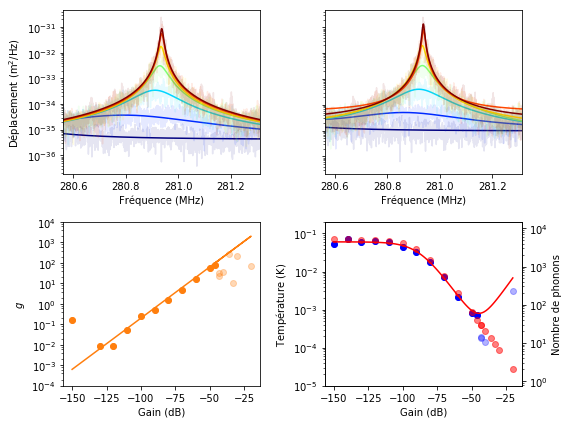

In [22]:
#Calibrated spectra

%matplotlib inline

from users.remi import feedback_cooling as fc
from users.remi import thermometry as th
import matplotlib.colors as mcol
import matplotlib.cm as cm

parent = CurveDB.get(184062)
curves = parent.childs.all()

Q = 29000

fig = plt.figure(figsize=(8,6))

sps = (2,2)
ax3 = plt.subplot2grid(sps, (0,0))
ax4 = plt.subplot2grid(sps, (1,0))
ax1 = plt.subplot2grid(sps, (0,1))
ax2 = plt.subplot2grid(sps, (1,1))
ax3.set_ylabel(u"$\\rm{Déplacement\ (m^2/Hz)}$")
ax1.set_xlabel(u"Fréquence (MHz)")
ax3.set_xlabel(u"Fréquence (MHz)")
ax2.set_xlabel(u"Gain (dB)")
ax2.set_ylabel(u"$\\rm{Température \ (K)}$")
ax4.set_xlabel(u"Gain (dB)")
ax4.set_ylabel(u"$g$")

gain, teff, tenv, nph, Qs, x0 = [], [], [], [], [], []
gain_hom, teff_hom, tenv_hom, nph_hom, Qs_hom, x0_hom, teff_hom_rugar, tenv_hom_rugar, gain_hom_rugar, teff_ba = [], [], [], [], [], [], [], [], [], []
main_gain, main_gain_hom_rugar, main_teff_hom_rugar = [], [], []
main_teff, main_tenv = [], []

i = 0
for c in curves[:]:
    peak = c.childs.filter(_name__contains="peak PDH")[0]
    if peak.childs.first() is not None:
        fit = peak.childs.first()
        if "x1" in fit.params:
            fit.params["Q"] = fit.params["x1"]/fit.params["bandwidth1"]
            fit.params["x0"] = fit.params["x1"]
            fit.save()
    gain.append(c.params["gain"])
    teff.append(peak.params["Teff"])
    tenv.append(peak.params["Tenv"])
    nph.append(peak.params["nph"])
    Qs.append(fit.params["Q"])
    x0.append(fit.params["x0"])
    peak_hom = c.childs.filter(_name__contains="homodyne")[0].childs.first()
    if peak_hom.childs.first() is not None:
        fit_hom = peak.childs.first()
    else:
        fit_hom = peak.fit("lorentz", autosave=False)
    gain_hom.append(c.params["gain"])
    teff_hom.append(peak_hom.params["Teff"])
    tenv_hom.append(peak_hom.params["Tenv"])
    nph_hom.append(peak_hom.params["nph"])
    Qs_hom.append(fit_hom.params["Q"])
    x0_hom.append(fit_hom.params["x0"])
    fixed_params={'Q0':Q}
    fit_hom_rugar = peak_hom.fit("Sxn",
                                 manualguess_params={'g':gain[-1], 'f0':fit.params["x0"], 'Snoise':1e-36, 'Tenv':60.e-3},
                                 fixed_params=fixed_params,
                                 error_function="log_error_vector", autosave=False)
    teffhomrugar = th.Tmode(f0=fit_hom_rugar.params["f0"], g=fit_hom_rugar.params["g"],
                    Sxn=fit_hom_rugar.params["Snoise"], Tenv=fit_hom_rugar.params["Tenv"],
                    Q0=fit_hom_rugar.params["Q0"], mass=112e-9)
    teff_hom_rugar.append(teffhomrugar)
    tenv_hom_rugar.append(fit_hom_rugar.params["Tenv"])
    gain_hom_rugar.append(fit_hom_rugar.params["g"])
    
    if gain[-1] < -43:
        main_gain.append(gain[-1])
        main_gain_hom_rugar.append(fit_hom_rugar.params["g"])
        main_teff_hom_rugar.append(teffhomrugar)
        main_teff.append(teff[-1])
        main_tenv.append(tenv[-1])

usefullgain = [-40, -50, -60, -70, -80, -90, -100]
colormap = plt.cm.jet
colorst = [colormap(i) for i in np.linspace(0, 1, len(usefullgain))]
for i, g in enumerate(usefullgain):
    for c in curves:
        peak = c.childs.filter(_name__contains="peak PDH")[0]
        if c.params["gain"]==g and peak.pk not in [184320,184372]:          
            fit = peak.childs.filter(_name__contains="fit")[0]
            ax1.semilogy(peak.data.index.values*1e-3, peak.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            ax1.semilogy(fit.data.index.values*1e-3, fit.data.values,
                        "-", color=colorst[i])
            peak_hom = c.childs.filter(_name__contains="homodyne")[0].childs.first()
            fit_hom = peak_hom.childs.first()
            ax3.semilogy(peak_hom.data.index.values*1e-3, peak_hom.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            #ax3.semilogy(fit_hom.data.index.values*1e-6, fit_hom.data.values,
            #            "-", color=colorst[i], label="g = %.0f dB"%(peak.params["gain"]))
            g = 10**(4.5+g/20.)
            x = peak_hom.data.index.values
            y = th.Sxxn(x, fit.params["x0"], 1e-36, g, 1e6, 60e-3, 112e-9)
            fixed_params={'Q0':Q}
            fit_hom_rugar = peak_hom.fit("Sxn",
                                     manualguess_params={'Tenv':60.e-3, 'g':g, 'f0':fit.params["x0"], 'Snoise':1e-36},
                                     fixed_params=fixed_params,
                                     error_function="log_error_vector", autosave=False)
            ax3.semilogy(fit_hom_rugar.data.index.values*1e-3, fit_hom_rugar.data.values, "-", color=colorst[i])


span = 750
for ax in [ax1, ax3]:
    #ax.set_ylim(5e-37, 5e-33)
    ax.set_xlim((fc.center-span/2)*1e-3, (fc.center+span/2)*1e-3)
    #ax.set_xticks([3.578, 3.5782, 3.5784, 3.5786])

g = 10**(4.4+np.array(gain)/20.)

Tenv = 60e-3
f0 = fc.center
omega0 = 2.*np.pi*f0
meff = 112e-9

gamma0 = omega0/Q

ax2.semilogy(gain, np.array(teff), "ob", label="$T_{eff}$", alpha=0.3)
ax2.semilogy(main_gain, np.array(main_teff), "ob")
x = np.linspace(min(gain), max(gain), 101)
Teff = Tenv/(1.+x) + meff*gamma0*omega0**2/4/cst.k * (x**2/(1.+x))*1e-36
Teff = th.Tmode(f0=omega0/2./np.pi, g=10**(4.4+np.array(x)/20.), Sxn=0.7e-35, Tenv=60e-3, Q0=Q, mass=meff)
Teff = th.Tmode(f0=omega0/2./np.pi, g=10**(4.4+np.array(x)/20.), Sxn=7e-36, Tenv=60e-3, Q0=Q, mass=meff)
ax2.semilogy(x, Teff, "-r")

ax2.set_ylim(1e-5, 2e-1)
ax2b = ax2.twinx()
ax2b.set_yscale("log")
ax2b.set_ylim(cst.k*ax2.get_ylim()[0]/cst.hbar/(2.*np.pi*np.mean(x0)),
              cst.k*ax2.get_ylim()[1]/cst.hbar/(2.*np.pi*np.mean(x0)))
ax2b.set_ylabel("Nombre de phonons")
ax2.semilogy(gain, np.array(teff).max()/(1.+np.array(g)), "or", alpha=0.5)

ax4.semilogy(gain, gain_hom_rugar, "oC1", alpha= 0.3)
ax4.semilogy(main_gain, main_gain_hom_rugar, "oC1")

ax4.semilogy(gain, np.array(g)*0.8, "-C1")
#ax4.semilogy(gain, np.array(g), "-C1")

ax4.set_ylim(1e-4, 1e4)
ax1.set_yticklabels([])
plt.tight_layout()
mysavefig("feedback_cooling_wheel_def.png")

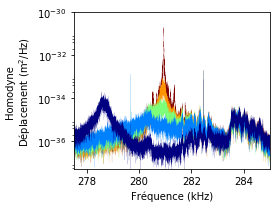

In [43]:
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(4,3))

pks = [184063, 184099, 184103, 184107, 184111]
colormap = plt.cm.jet
colorst = [colormap(i) for i in np.linspace(0, 1, len(pks))][::-1]

ax.set_xlim(277.5, 285)
ax.set_ylim(5e-38, 1e-30)
ax.set_ylabel(u"Homodyne\n$\\rm{Déplacement\ (m^2/Hz)}$")
ax.set_xlabel(u"Fréquence (kHz)")
for i, pk in enumerate(pks):
    c = CurveDB.get(pk)
    c = c.childs.first()
    plt.semilogy(c.data.index.values*1e-3, c.data.values, color=colorst[i], linewidth=0.1)
    mysavefig("homodyne_noise"+str(i)+".png")

g =  -150 dB, Q =    29165, Teff =   53.700 mK, Tenv =  1.6 K, n = 3983
g =  -140 dB, Q =    46490, Teff =   69.631 mK, Tenv =  1.6 K, n = 5164
g =  -130 dB, Q =    38598, Teff =   57.817 mK, Tenv =  1.5 K, n = 4288
g =  -120 dB, Q =    30429, Teff =   61.369 mK, Tenv =  1.5 K, n = 4551
g =  -110 dB, Q =    34608, Teff =   59.470 mK, Tenv =  1.6 K, n = 4411
g =  -100 dB, Q =    30648, Teff =   43.752 mK, Tenv =  1.4 K, n = 3245
g =   -90 dB, Q =    26370, Teff =   33.095 mK, Tenv =  1.3 K, n = 2455
g =   -80 dB, Q =    11694, Teff =   17.297 mK, Tenv =  1.1 K, n = 1283
g =   -70 dB, Q =     8965, Teff =    7.044 mK, Tenv =  1.1 K, n = 522
g =   -60 dB, Q =     3377, Teff =    2.197 mK, Tenv =  1.0 K, n = 163
g =   -50 dB, Q =     1283, Teff =    0.831 mK, Tenv =  1.4 K, n = 62


KeyboardInterrupt: 

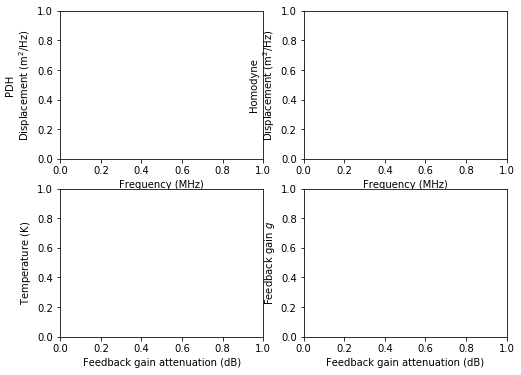

In [10]:
#Calibrated spectra

%matplotlib inline

from users.remi import feedback_cooling as fc
from users.remi import thermometry as th
import matplotlib.colors as mcol
import matplotlib.cm as cm

parent = CurveDB.get(184062)
curves = parent.childs.all()

Q = 29000

fig = plt.figure(figsize=(8,6))

sps = (2,2)
ax1 = plt.subplot2grid(sps, (0,0))
ax2 = plt.subplot2grid(sps, (1,0))
ax3 = plt.subplot2grid(sps, (0,1))
ax4 = plt.subplot2grid(sps, (1,1))
ax1.set_ylabel("PDH\n$\\rm{Displacement\ (m^2/Hz)}$")
ax3.set_ylabel("Homodyne\n$\\rm{Displacement\ (m^2/Hz)}$")
ax1.set_xlabel("Frequency (MHz)")
ax3.set_xlabel("Frequency (MHz)")
ax2.set_xlabel("Feedback gain attenuation (dB)")
ax2.set_ylabel("$\\rm{Temperature \ (K)}$")
ax4.set_xlabel("Feedback gain attenuation (dB)")
ax4.set_ylabel("Feedback gain $g$")

gain, teff, tenv, nph, Qs, x0 = [], [], [], [], [], []
gain_hom, teff_hom, tenv_hom, nph_hom, Qs_hom, x0_hom, teff_hom_rugar, tenv_hom_rugar, gain_hom_rugar, teff_ba = [], [], [], [], [], [], [], [], [], []
main_gain, main_gain_hom_rugar, main_teff_hom_rugar = [], [], []
main_teff, main_tenv = [], []

i = 0
for c in curves[:]:
    peak = c.childs.filter(_name__contains="peak PDH")[0]
    if peak.childs.first() is not None:
        fit = peak.childs.first()
        if "x1" in fit.params:
            fit.params["Q"] = fit.params["x1"]/fit.params["bandwidth1"]
            fit.params["x0"] = fit.params["x1"]
            fit.save()
    gain.append(c.params["gain"])
    teff.append(peak.params["Teff"])
    tenv.append(peak.params["Tenv"])
    nph.append(peak.params["nph"])
    Qs.append(fit.params["Q"])
    x0.append(fit.params["x0"])
    peak_hom = c.childs.filter(_name__contains="homodyne")[0].childs.first()
    print "g = %5.0f dB, Q = %8.0f, Teff = %8.3f mK, Tenv = %4.1f K, n = %.0f"%(c.params["gain"],
                                                                        fit.params["Q"],
                                                                        peak.params["Teff"]*1e3,
                                                                        peak.params["Tenv"],
                                                                        peak.params["nph"])
    if peak_hom.childs.first() is not None:
        fit_hom = peak.childs.first()
    else:
        fit_hom = peak.fit("lorentz", autosave=False)
    gain_hom.append(c.params["gain"])
    teff_hom.append(peak_hom.params["Teff"])
    tenv_hom.append(peak_hom.params["Tenv"])
    nph_hom.append(peak_hom.params["nph"])
    Qs_hom.append(fit_hom.params["Q"])
    x0_hom.append(fit_hom.params["x0"])
    fixed_params={'Q0':Q}
    fit_hom_rugar = peak_hom.fit("Sxn",
                                 manualguess_params={'g':gain[-1], 'f0':fit.params["x0"], 'Snoise':1e-36, 'Tenv':60.e-3},
                                 fixed_params=fixed_params,
                                 error_function="log_error_vector", autosave=False)
    teffhomrugar = th.Tmode(f0=fit_hom_rugar.params["f0"], g=fit_hom_rugar.params["g"],
                    Sxn=fit_hom_rugar.params["Snoise"], Tenv=fit_hom_rugar.params["Tenv"],
                    Q0=fit_hom_rugar.params["Q0"], mass=112e-9)
    teff_hom_rugar.append(teffhomrugar)
    tenv_hom_rugar.append(fit_hom_rugar.params["Tenv"])
    gain_hom_rugar.append(fit_hom_rugar.params["g"])
    
    if gain[-1] < -43:
        main_gain.append(gain[-1])
        main_gain_hom_rugar.append(fit_hom_rugar.params["g"])
        main_teff_hom_rugar.append(teffhomrugar)
        main_teff.append(teff[-1])
        main_tenv.append(tenv[-1])

usefullgain = [-40, -50, -60, -70, -80, -90, -100]
colormap = plt.cm.jet
colorst = [colormap(i) for i in np.linspace(0, 1, len(usefullgain))]
for i, g in enumerate(usefullgain):
    for c in curves:
        peak = c.childs.filter(_name__contains="peak PDH")[0]
        if c.params["gain"]==g and peak.pk not in [184320,184372]:          
            fit = peak.childs.filter(_name__contains="fit")[0]
            ax1.semilogy(peak.data.index.values*1e-3, peak.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            ax1.semilogy(fit.data.index.values*1e-3, fit.data.values,
                        "-", color=colorst[i])
            peak_hom = c.childs.filter(_name__contains="homodyne")[0].childs.first()
            fit_hom = peak_hom.childs.first()
            ax3.semilogy(peak_hom.data.index.values*1e-3, peak_hom.data.values, "-", color=colorst[i], markersize=1, alpha=0.1)
            #ax3.semilogy(fit_hom.data.index.values*1e-6, fit_hom.data.values,
            #            "-", color=colorst[i], label="g = %.0f dB"%(peak.params["gain"]))
            g = 10**(4.5+g/20.)
            x = peak_hom.data.index.values
            y = th.Sxxn(x, fit.params["x0"], 1e-36, g, 1e6, 60e-3, 112e-9)
            fixed_params={'Q0':Q}
            fit_hom_rugar = peak_hom.fit("Sxn",
                                     manualguess_params={'Tenv':60.e-3, 'g':g, 'f0':fit.params["x0"], 'Snoise':1e-36},
                                     fixed_params=fixed_params,
                                     error_function="log_error_vector", autosave=False)
            ax3.semilogy(fit_hom_rugar.data.index.values*1e-3, fit_hom_rugar.data.values, "-", color=colorst[i])


span = 750
for ax in [ax1, ax3]:
    #ax.set_ylim(5e-37, 5e-33)
    ax.set_xlim((fc.center-span/2)*1e-3, (fc.center+span/2)*1e-3)
    #ax.set_xticks([3.578, 3.5782, 3.5784, 3.5786])

g = 10**(4.3+np.array(gain)/20.)

Tenv = 60e-3
f0 = fc.center
omega0 = 2.*np.pi*f0
meff = 112e-9

gamma0 = omega0/Q

ax2.semilogy(gain, np.array(teff), "oC0", label="$T_{eff}$", alpha=0.3)
ax2.semilogy(main_gain, np.array(main_teff), "oC0")
ax2.semilogy(gain, tenv, "oC1", label="$T_{env}$", alpha=0.3)
ax2.semilogy(main_gain, main_tenv, "oC1")
x = np.linspace(min(gain), max(gain), 101)
Teff = Tenv/(1.+x) + meff*gamma0*omega0**2/4/cst.k * (x**2/(1.+x))*1e-36
Teff = th.Tmode(f0=omega0/2./np.pi, g=10**(4.5+np.array(x)/20.), Sxn=0.7e-35, Tenv=60e-3, Q0=Q, mass=meff)
print min(Teff)
Teff = th.Tmode(f0=omega0/2./np.pi, g=10**(4.5+np.array(x)/20.), Sxn=7e-36, Tenv=60e-3, Q0=Q, mass=meff)
ax2.semilogy(x, Teff, "-C2")
Teff = th.Tmode(f0=omega0/2./np.pi, g=10**(4.5+np.array(x)/20.), Sxn=5e-37, Tenv=60e-3, Q0=Q, mass=meff)
ax2.semilogy(x, Teff, "--C2")
ax2.semilogy(gain, teff_hom_rugar, "oC3", alpha=0.3)
ax2.semilogy(main_gain, main_teff_hom_rugar, "oC3")

ax2.set_ylim(1e-4, 1e2)
ax2b = ax2.twinx()
ax2b.set_yscale("log")
ax2b.set_ylim(cst.k*ax2.get_ylim()[0]/cst.hbar/(2.*np.pi*np.mean(x0)),
              cst.k*ax2.get_ylim()[1]/cst.hbar/(2.*np.pi*np.mean(x0)))
ax2b.set_ylabel("Mean phonon number")

ax4.semilogy(gain, gain_hom_rugar, "oC0", alpha= 0.3)
ax4.semilogy(main_gain, main_gain_hom_rugar, "oC0")

ax4.semilogy(gain, g, "-")

#ax4.plot(gain, min(np.array(x0)/np.array(Qs))*(1.+g), "o")
ax4.set_ylim(1e-4, 1e4)
plt.tight_layout()
mysavefig("feedback_cooling_wheel.png")

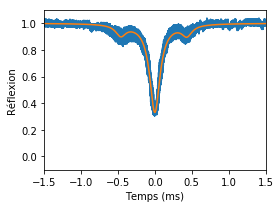

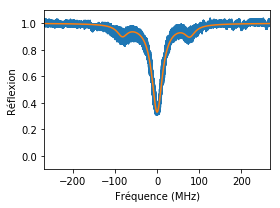

In [14]:
%matplotlib inline
from pyinstruments import CurveDB

c = CurveDB.get(151494)
fit = c.childs.first()
y0 = fit.params["y0"]
x0 = fit.params["x0"]
sbwidth = fit.params["SBwidth"]

fig, ax = plt.subplots(1,1, figsize=(4,3))
factor = 1e3
plt.plot((c.data.index.values-x0)*factor, c.data.values/y0, label="data")
plt.plot((fit.data.index.values-x0)*factor, fit.data.values/y0, label="fit")
plt.xlabel(u"Temps (ms)")
plt.ylabel(u"Réflexion")
plt.xlim(-0.0015*factor, 0.0015*factor)
plt.ylim(-0.1,1.1)
mysavefig("resonance_time.png")

fig, ax = plt.subplots(1,1, figsize=(4,3))
factor = 80/sbwidth
plt.plot((c.data.index.values-x0)*factor, c.data.values/y0, label="data")
plt.plot((fit.data.index.values-x0)*factor, fit.data.values/y0, label="fit")
plt.xlabel(u"Fréquence (MHz)")
plt.ylabel(u"Réflexion")
plt.xlim(-0.0015*factor, 0.0015*factor)
plt.ylim(-0.1,1.1)
mysavefig("resonance_frequency.png")

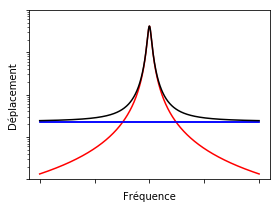

In [42]:
##### SQL #####

def I(P, wavelength=1064e-9):
    nu = cst.c/wavelength
    return P/cst.h/nu

def phase_noise(P,F, wavelength=1064e-9):
    return wavelength/16./F/np.sqrt(I(P, wavelength=wavelength))

def Sxx_phase(P,F, wavelength=1064e-9):
    return (phase_noise(P,F, wavelength=wavelength))**2

def chi(f, m=33.5e-9, f0=3.6e6, Q=1e6):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    return 1./m/((omega0**2-omega**2)-1j*gamma*omega)

def Sxx_ampl(f, P, F, wavelength=1064e-9, m=33.5e-9, f0=3.6e6, Q=1e6):
    omega = 2.*np.pi*f
    return 64.*cst.hbar**2*F**2*np.abs(chi(f, m=m, f0=f0, Q=Q))**2*I(P, wavelength=wavelength)/wavelength**2

def thermal_peak(f, m=33.5e-9, f0=3.6e6, Q=1e6, T=00.):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    return 2.*cst.k*T*gamma/m/((omega0**2-omega**2)**2+gamma**2*omega**2)

## Rugar
def Sxx(f, m=33.5e-9, f0=3.6e6, Q=1e6, T=300., Sxn=0., g=0.):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    susc = 1./((omega0**2-omega**2)**2+(1.+g)**2*gamma**2*omega**2)
    thermal = 2.*cst.k*T*gamma/m
    noise = g**2*gamma**2*omega**2*Sxn
    return susc*(thermal+noise)

def Sxx_meas(f, m=33.5e-9, f0=3.6e6, Q=1e6, T=300., Sxn=0., g=0.):
    omega0 = 2.*np.pi*f0
    omega = 2.*np.pi*f
    gamma = omega0/Q
    susc = 1./((omega0**2-omega**2)**2+(1.+g)**2*gamma**2*omega**2)
    thermal = 2.*cst.k*T*gamma/m
    noise = ((omega0**2-omega**2)**2+gamma**2*omega**2)*Sxn
    return susc*(thermal+noise)

fig = plt.figure(figsize=(4,3))
sps = (1,1)
ax = plt.subplot2grid(sps, (0,0))

T = 80e-3
f0 = 3.6e6
meff = 33.5e-9
Q = 1e6
F = 60e3
span = 200.
f = np.linspace(f0-span/2., f0+span/2, 1001)
x = (f-f0)
P = 1e-6
Sxn = Sxx_phase(P,F)
omega0 = 2.*np.pi*f0
gamma = omega0/Q


y_thermal = thermal_peak(f, m=meff, f0=f0, Q=Q, T=T)
y_phase = Sxx_phase(P,F)*np.ones(len(x))
y_rad = Sxx_ampl(f, P, F, m=meff, f0=f0, Q=Q)
y_real_rug = Sxx(f, m=meff, f0=f0, Q=Q, T=Tenv, Sxn=Sxn, g=g)
y_meas_rug = Sxx_meas(f, m=meff, f0=f0, Q=Q, T=Tenv, Sxn=Sxn, g=g)

#ax.fill_between(x, 0, y, where=y >= 0, facecolor="C0", alpha=0.2, interpolate=True)
ax.semilogy(x, y_phase, "-b")
ax.semilogy(x, y_rad, "-r")
ax.semilogy(x, y_phase, "-b")
ax.semilogy(x, y_rad+y_phase, "-k")
ax.set_ylim(1e-38, 1e-34)
ax.set_xlabel(u"Fréquence")
ax.set_ylabel(u"Déplacement")
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.tight_layout()

mysavefig("quantum_noises_peak.png")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

def I(P, wavelength=1064e-9):
    nu = cst.c/wavelength
    return P/cst.h/nu

def phase_noise(P,F, wavelength=1064e-9):
    return wavelength/16./F/np.sqrt(I(P, wavelength=wavelength))

def Sxx_phase(P,F, wavelength=1064e-9):
    return (phase_noise(P,F, wavelength=wavelength))**2

def gamma(delta, P):
    fact = P/cst.hbar/omegal*kappa_in/(delta**2+kappa**2/4)
    fact1 = kappa/(kappa**2/4+(delta+omega0)**2)
    fact2 = kappa/(kappa**2/4+(delta-omega0)**2)
    return g0**2*fact*(fact1-fact2)

T = 80e-3
f0 = 3.6e6
F = 60e3
length = 100e-6
tau = 2.*length/cst.c
linewidth = 1./F/tau
kappa = 2.*np.pi*linewidth
kappa_in = 80e-6/tau
span = 4.*kappa
x = (f-f0)
omega0 = 2.*np.pi*f0
G = 4.*np.pi/1064e-9/tau
x_zpf = np.sqrt(cst.hbar/2./meff/omega0)
g0 = G*x_zpf
omegal = 2.*np.pi*cst.c/1064e-9
meff = 33.5e-9
Q = 1e6
gamma0 = omega0/Q

def T_min_fb(P):
    Sxn = Sxx_phase(P,F)
    return np.sqrt(meff*gamma0*omega0**2*T*Sxn/cst.k)
def T_min_sc(P):
        delta = np.linspace(-span/2., span/2., 100)
        gamma_opt = max(gamma(delta, P))
        gamma_eff = gamma_opt+gamma0
        return T*gamma0/gamma_eff
P = np.logspace(-7,-1, 101)
Tenv = np.ones(len(P))*T
plt.loglog(P, Tenv)
plt.loglog(P, T_min_fb(P))
T_min_scs = []
for p in P:
    T_min_scs.append(T_min_sc(p))
plt.loglog(P, T_min_scs)

plt.xlabel("P (W)")
plt.ylabel("$T_\mathrm{min}$ (K)")

mysavefig("fb_sc_comparison.png")